In [1]:
# This Jupyter Notebook is courtesy of Vanessa Yan and Github user hpan55.
# Original work can be found at: https://github.com/VanessaYan/STAT-453-Malaria-Bounding-Boxes-Detection
# This work was modified for usage by Team 0106A as part of the design course ESC204 for testing and proof of concept purposes.

In [54]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import math

In [16]:
from __future__ import print_function

from collections import defaultdict, deque
import datetime
import pickle
import time
import torch.distributed as dist
import errno

import collections
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [17]:
from pathlib import Path
from matplotlib import patches

# Tools

In [18]:
### cite https://www.kaggle.com/abhishek/train-your-own-mask-rcnn

class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [19]:
### cite https://www.kaggle.com/abhishek/train-your-own-mask-rcnn
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [20]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.eval()
model.to(device)


/home/awu/.conda/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/awu/.conda/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [21]:
for param in model.parameters():
    param.requires_grad = True

In [22]:
# category 1-uninfected 2-infected 0-background
train= pd.read_csv ('/home/awu/ML/Praxis-III/slide_analysis/data/train/train_df.csv')
train['category'][train['category']=='uninfected']=1
train['category'][train['category']=='infected']=2

/tmp/ipykernel_644131/1719707575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['category'][train['category']=='uninfected']=1
/tmp/ipykernel_644131/1719707575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['category'][train['category']=='infected']=2


In [23]:
test= pd.read_csv ('/home/awu/ML/Praxis-III/slide_analysis/data/test/test_df.csv')
test['category'][test['category']=='uninfected']=1
test['category'][test['category']=='infected']=2

/tmp/ipykernel_644131/895775150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['category'][test['category']=='uninfected']=1
/tmp/ipykernel_644131/895775150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['category'][test['category']=='infected']=2


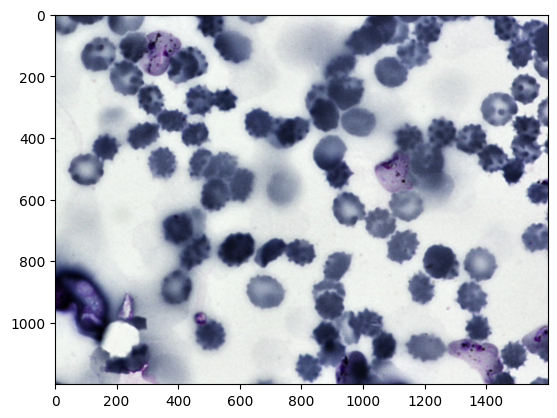

In [25]:

image = plt.imread(test['path'][0])

plt.imshow(image)

In [26]:
train_2 = pd.DataFrame(columns=('path','labels','boxes'))
for i in train['path'].unique():
    df_i = train[train['path']==i]
    labels = []
    boxes = []
    for j in df_i.index:
        labels.append(df_i['category'][j])
        boxes.append([df_i['x1'][j],df_i['y1'][j],df_i['x2'][j],df_i['y2'][j]])
    train_2 = pd.concat([train_2,pd.DataFrame({
        'path':[i],
        'labels':[labels],
        'boxes':[boxes]
    })],ignore_index=True)

In [27]:
test_2 = pd.DataFrame(columns=('path','labels','boxes'))
for i in test['path'].unique():
    df_i = test[test['path']==i]
    labels = []
    boxes = []
    for j in df_i.index:
        labels.append(df_i['category'][j])
        boxes.append([df_i['x1'][j],df_i['y1'][j],df_i['x2'][j],df_i['y2'][j]])
    test_2 = pd.concat([test_2,pd.DataFrame({
        'path':[i],
        'labels':[labels],
        'boxes':[boxes]
    })],ignore_index=True)

In [28]:
train_2.head()

,path,labels,boxes
0,/home/awu/ML/Praxis-III/slide_analysis/malaria...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1440, 1057, 1540, 1158], [1303, 868, 1403, 9..."
1,/home/awu/ML/Praxis-III/slide_analysis/malaria...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[735, 734, 834, 832], [1283, 939, 1378, 1039]..."
2,/home/awu/ML/Praxis-III/slide_analysis/malaria...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1027, 724, 1136, 834], [1155, 287, 1254, 387..."
3,/home/awu/ML/Praxis-III/slide_analysis/malaria...,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1421, 563, 1545, 656], [324, 208, 446, 337],..."
4,/home/awu/ML/Praxis-III/slide_analysis/malaria...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[688, 618, 810, 744], [1035, 689, 1168, 819],..."


In [29]:
class MalariaDataset(torch.utils.data.Dataset):    

    def __init__(self, df, img_dir): #df = train #img_dir = '../malaria/images/'
        self.df = df
        self.height = 256
        self.width = 256
        self.img_dir = img_dir
        
    def __getitem__(self, idx):
        img = Image.open(self.df['path'][idx])
        width, height = img.size
        img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        boxes = torch.as_tensor(self.df['boxes'][idx], dtype=torch.float32)
        for i in range(len(boxes)):
          boxes[i][0] = boxes[i][0]/(width/self.width)
          boxes[i][1] = boxes[i][1]/(height/self.width)
          boxes[i][2] = boxes[i][2]/(width/self.width)
          boxes[i][3] = boxes[i][3]/(height/self.width)
        labels = torch.as_tensor((self.df['labels'][idx]), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.tensor([0])  ###
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return transforms.ToTensor()(img), target

    def __len__(self):
        return len(self.df)

In [30]:
dataset_train = MalariaDataset(train_2, '/home/awu/ML/Praxis-III/slide_analysis/malaria/images/')

In [31]:
dataset_test = MalariaDataset(test_2, '/home/awu/ML/Praxis-III/slide_analysis/malaria/images/')

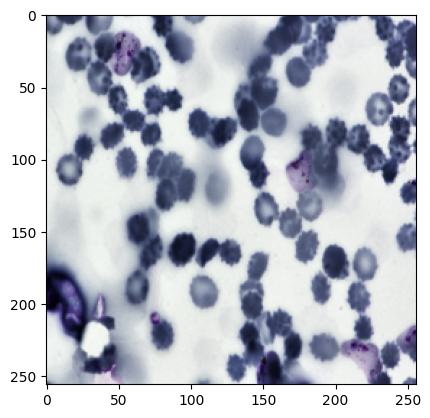

In [32]:
plt.imshow(dataset_train.__getitem__(0)[0].permute(1, 2, 0))

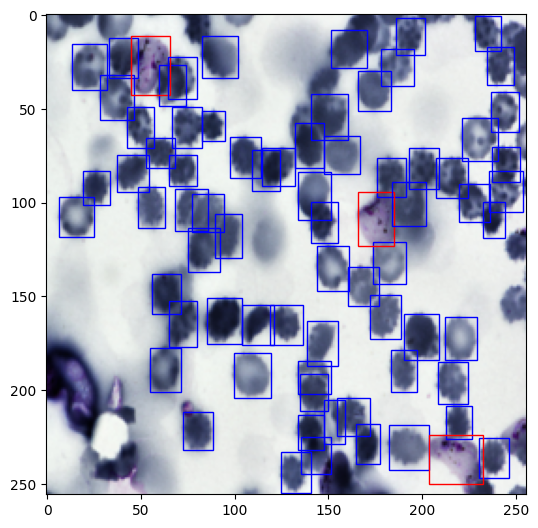

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
image = plt.imshow(dataset_train.__getitem__(0)[0].permute(1, 2, 0))
box_lab = dataset_train.__getitem__(0)[1]
for i in range(box_lab['boxes'].shape[0]):
    xmin = box_lab['boxes'][i][0]
    xmax = box_lab['boxes'][i][2]
    ymin = box_lab['boxes'][i][1]
    ymax = box_lab['boxes'][i][3]
    wid = xmax - xmin
    hei = ymax - ymin   
    if box_lab['labels'][i] == 2:
        edgecolor = 'r'
    elif box_lab['labels'][i] == 1:
        edgecolor = 'b'
    rect = patches.Rectangle((xmin,ymin), wid, hei, edgecolor = edgecolor, facecolor = 'none')    
    ax.add_patch(rect)

In [34]:
len(dataset_train)

1208

In [35]:
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x)))

In [36]:
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x)))

Define Training Parameters

In [37]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

In [39]:
# device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [24]:
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()

Epoch: [0]  [  0/274]  eta: 0:11:09  lr: 0.000023  loss: 3.8415 (3.8415)  loss_classifier: 1.1232 (1.1232)  loss_box_reg: 0.7363 (0.7363)  loss_objectness: 1.9419 (1.9419)  loss_rpn_box_reg: 0.0400 (0.0400)  time: 2.4418  data: 0.2631  max mem: 3847
Epoch: [0]  [100/274]  eta: 0:01:43  lr: 0.001853  loss: 0.4157 (0.8542)  loss_classifier: 0.1590 (0.3199)  loss_box_reg: 0.2224 (0.3953)  loss_objectness: 0.0078 (0.1060)  loss_rpn_box_reg: 0.0197 (0.0329)  time: 0.5644  data: 0.0039  max mem: 4355
Epoch: [0]  [200/274]  eta: 0:00:42  lr: 0.003683  loss: 0.3506 (0.6326)  loss_classifier: 0.1245 (0.2355)  loss_box_reg: 0.2012 (0.3128)  loss_objectness: 0.0058 (0.0576)  loss_rpn_box_reg: 0.0196 (0.0267)  time: 0.5475  data: 0.0039  max mem: 4369
Epoch: [0]  [273/274]  eta: 0:00:00  lr: 0.005000  loss: 0.3182 (0.5525)  loss_classifier: 0.1112 (0.2030)  loss_box_reg: 0.1931 (0.2811)  loss_objectness: 0.0032 (0.0436)  loss_rpn_box_reg: 0.0177 (0.0246)  time: 0.5486  data: 0.0039  max mem: 4460


In [25]:
torch.save(model,'/home/awu/ML/Praxis-III/slide_analysis/data/weights/faster_lr1_0.005.pt')

In [40]:
model = torch.load('/home/awu/STAT-453-Malaria-Bounding-Boxes-Detection-master/Data/faster_lr1_0.005.pt')

### Result run on desktop:

75.87% = infected AP 

91.24% = uninfected AP

mAP = 83.56%

In [48]:
def faster_rcnn_test(img_path,threshold):
    img = Image.open(img_path)
    img = img.resize((256, 256), resample=Image.BILINEAR)
    img = transforms.ToTensor()(img)
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        pred = model([img.to(device)])
    print('Time cost for prediction: %.2f s' % ((time.time() - start_time)))
    cell = ['background','uninfected','infected']
    threshold = threshold
    pred_class = [cell[i] for i in list(pred[0]['labels'])]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach())]
    pred_score = list(pred[0]['scores'].detach())
    pred_t = [pred_score.index(x) for x in pred_score if x>=threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.title("Predicted Boxes with Labels")
    image = plt.imshow(img.permute(1, 2, 0))
    num_infected = 0
    for i in range(len(pred_boxes)):
        xmin = pred_boxes[i][0][0].cpu()
        xmax = pred_boxes[i][1][0].cpu()
        ymin = pred_boxes[i][0][1].cpu()
        ymax = pred_boxes[i][1][1].cpu()
        wid = xmax - xmin
        hei = ymax - ymin
        if pred_class[i] == 'infected':
            edgecolor = 'r'
            num_infected += 1
        elif pred_class[i] == 'uninfected':
            edgecolor = 'b'
        rect = patches.Rectangle((xmin,ymin), wid, hei, edgecolor = edgecolor, facecolor = 'none')    
        ax.add_patch(rect)
        ax.text(xmin,ymin,pred_score[i].cpu().numpy().round(3).astype('str'))
    print("number of parasitized cells:", num_infected)

Time cost for prediction: 0.07 s
number of parasitized cells: 0


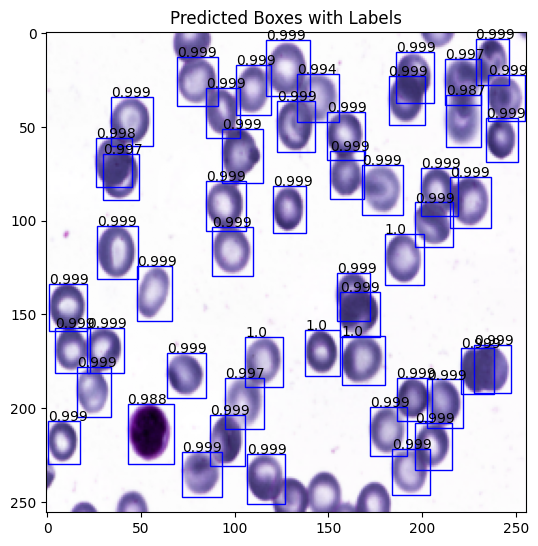

In [49]:
faster_rcnn_test(train_2['path'][400],0.8)

In [50]:
def true_label(img_path,dataset):
  img = Image.open(img_path)
  width, height = img.size
  img = img.resize((256, 256), resample=Image.BILINEAR)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  plt.title("True Boxes with Labels")
  plt.imshow(img)
  for _,row in dataset[dataset.path == img_path].iterrows():
      xmin = row.x1/(width/256)
      xmax = row.x2/(width/256)
      ymin = row.y1/(height/256)
      ymax = row.y2/(height/256)
      wid = xmax - xmin
      hei = ymax - ymin
      if row.category == 2:
          edgecolor = 'r'
      elif row.category == 1:
          edgecolor = 'b'
      rect = patches.Rectangle((xmin,ymin), wid, hei, edgecolor = edgecolor, facecolor = 'none')    
      ax.add_patch(rect)

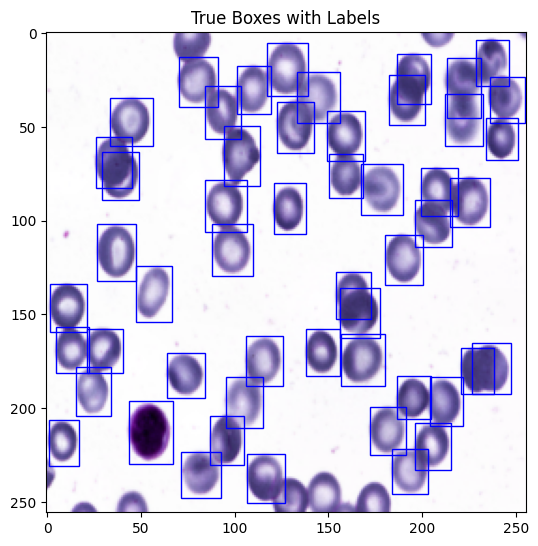

In [51]:
true_label(train_2['path'][400],train)

Time cost for prediction: 0.06 s
number of parasitized cells: 3


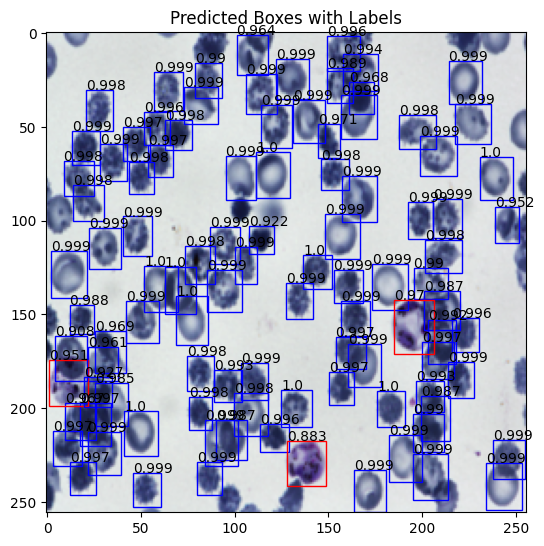

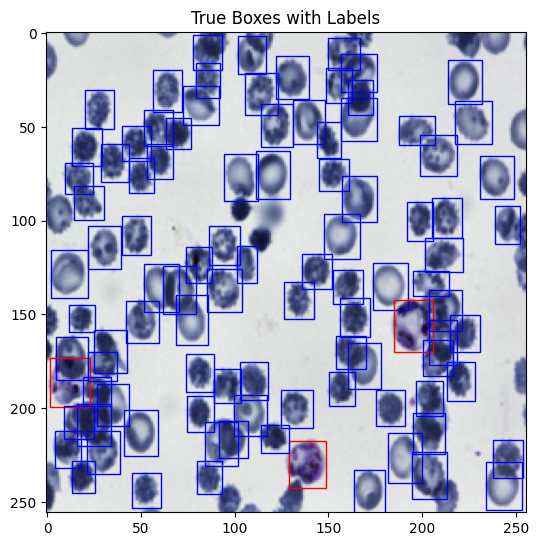

In [52]:
faster_rcnn_test(train_2['path'][1001],0.8)
true_label(train_2['path'][1001],train)

In [77]:
#ESC204 Density Calculation

def faster_rcnn_inference(img_path,threshold):
    img = Image.open(img_path)
    img = img.resize((256, 256), resample=Image.BILINEAR)
    img = transforms.ToTensor()(img)
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        pred = model([img.to(device)])
    cell = ['background','uninfected','infected']
    threshold = threshold
    pred_class = [cell[i] for i in list(pred[0]['labels'])]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach())]
    pred_score = list(pred[0]['scores'].detach())
    pred_t = [pred_score.index(x) for x in pred_score if x>=threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]

    num_infected = 0
    num_uninfected = 0
    for i in range(len(pred_boxes)):
        xmin = pred_boxes[i][0][0].cpu()
        xmax = pred_boxes[i][1][0].cpu()
        ymin = pred_boxes[i][0][1].cpu()
        ymax = pred_boxes[i][1][1].cpu()
        wid = xmax - xmin
        hei = ymax - ymin
        if pred_class[i] == 'infected':
            edgecolor = 'r'
            num_infected += 1
        elif pred_class[i] == 'uninfected':
            edgecolor = 'b'
            num_uninfected += 1
    return num_infected, num_uninfected

# Density Calculation
# As proof of concept, approximate white blood cell count with red blood cell count
# #RBC ~ #800 WBC
# Total# = #WBC + #RBC = 801 * #WBC

def determine_density(num_images):
    total_num_infected = 0
    total_num_uninfected = 0
    density = 0
    total_num_cells = 0
    total_WBC = 0

    for num in range(num_images):
        inf, uninf = faster_rcnn_inference(test_2['path'][num],0.8)
        total_num_infected += inf
        total_num_uninfected += uninf
        total_num_cells = total_num_infected + total_num_uninfected
        total_WBC = math.ceil(total_num_cells / 801)

        if (total_WBC >= 200 and total_num_infected >= 100):
            density = total_num_infected*8000/total_WBC
            break
        if (total_WBC >= 500 and total_num_infected <= 99):
            density = total_num_infected*8000/total_WBC
            break
        else:
            density = total_num_infected*8000/total_WBC

        
    print("total number of infected cells:", total_num_infected)
    print("total number of uninfected cells", total_num_uninfected)
    print("estimated number of WBCs is", total_WBC)
    print("parasite density is:", density, " per microlitre of blood")

# Note: the resulting parasite density is considered severe.
# See: https://apps.who.int/iris/bitstream/handle/10665/79317/9789241548526_eng.pdf;jsessionid=368B33BC044D515E78E3C0C7AEEAAC3A?sequence=1
# Any other inaccuracies can be attributed to an inaccurate estimate of the white blood cell count,
# unrealisitc testing data, inaccuracies in the machine learning model, 
# and lack of machine learning detection for  white blood cells.

determine_density(100)


total number of infected cells: 147
total number of uninfected cells 5633
estimated number of WBCs is 8
parasite density is: 147000.0  per microlitre of blood


In [ ]:
def save_images(num_images):
    for count in range(num_images):
        img_path = test_2['path'][count]
        img = Image.open(img_path)
        img = img.resize((256, 256), resample=Image.BILINEAR)
        img = transforms.ToTensor()(img)
        model.eval()
        start_time = time.time()
        with torch.no_grad():
            pred = model([img.to(device)])
        
        cell = ['background','uninfected','infected']
        threshold = 0.8
        pred_class = [cell[i] for i in list(pred[0]['labels'])]
        pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach())]
        pred_score = list(pred[0]['scores'].detach())
        pred_t = [pred_score.index(x) for x in pred_score if x>=threshold][-1]
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]
        pred_score = pred_score[:pred_t+1]
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        plt.title("Predicted Boxes with Labels")
        image = plt.imshow(img.permute(1, 2, 0))
        num_infected = 0
        for i in range(len(pred_boxes)):
            xmin = pred_boxes[i][0][0].cpu()
            xmax = pred_boxes[i][1][0].cpu()
            ymin = pred_boxes[i][0][1].cpu()
            ymax = pred_boxes[i][1][1].cpu()
            wid = xmax - xmin
            hei = ymax - ymin
            if pred_class[i] == 'infected':
                edgecolor = 'r'
                num_infected += 1
            elif pred_class[i] == 'uninfected':
                edgecolor = 'b'
            rect = patches.Rectangle((xmin,ymin), wid, hei, edgecolor = edgecolor, facecolor = 'none')    
            ax.add_patch(rect)
            ax.text(xmin,ymin,pred_score[i].cpu().numpy().round(3).astype('str'))
        image_name = str(count) + "_prediction.jpg"
        plt.savefig(image_name, bbox_inches = "tight")
    
    for count in range(num_images):
        img = Image.open(img_path)
        width, height = img.size
        img = img.resize((256, 256), resample=Image.BILINEAR)
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        plt.title("True Boxes with Labels")
        plt.imshow(img)
        for _,row in train[train.path == img_path].iterrows():
            xmin = row.x1/(width/256)
            xmax = row.x2/(width/256)
            ymin = row.y1/(height/256)
            ymax = row.y2/(height/256)
            wid = xmax - xmin
            hei = ymax - ymin
            if row.category == 2:
                edgecolor = 'r'
            elif row.category == 1:
                edgecolor = 'b'
            rect = patches.Rectangle((xmin,ymin), wid, hei, edgecolor = edgecolor, facecolor = 'none')    
            ax.add_patch(rect)
        image_name = str(count) + "_true_label.jpg"
        plt.savefig(image_name, bbox_inches = "tight")

save_images(100)